In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.cm import ScalarMappable

%run ../functions/color_functions.py ./

The [first part](#part1) of this notebook computes the mean across all datasets from the same category. These results are already saved in the `data/hydrology_timeseries` folder so that you can skip this part and go directly to the [second part](#part2).

Basin shapes have been downloaded from the [GRDC website](https://www.bafg.de/GRDC/EN/02_srvcs/22_gslrs/221_MRB/riverbasins_2020.html?nn=201570#doc2731742bodyText2). The following table contains all basins with an area larger than $65,000 \ km^2$. It additionally indicates the continent where the basin is located, the ocean where water is discharged (if applicable), the basin discharge area, the main climate zone (with full names and abbreviations following the [Koppen-Geiger classification](http://worldmap.harvard.edu/data/geonode:koppen_geiger_climate_classification_rev_g21)), the area covered by the main climate zone, and the cluster determined by the hierarchical algorithm (see the dendrogram in the article). 

In [2]:
basins=geopandas.read_file('../data/basins/basins.shp').set_index('name')
basins.head()

,continent,ocean,area,climate,clim area,cluster,clim name,geometry
name,,,,,,,,
WINISK,"North America, Central America and the Caribbean",Arctic Ocean,65635.3,Dfc,99.743367,other,Snow fully humid cool summer,"POLYGON ((-87.24167 52.32500, -87.24223 52.314..."
COPPER,"North America, Central America and the Caribbean",Pacific Ocean,65704.3,Dfc,56.077317,other,Snow fully humid cool summer,"POLYGON ((-140.15833 61.00000, -140.15890 60.9..."
NOTTAWAY,"North America, Central America and the Caribbean",Arctic Ocean,66053.1,Dfc,96.210946,other,Snow fully humid cool summer,"MULTIPOLYGON (((-73.85417 50.00833, -73.85089 ..."
TALAS,Asia,---,66179.8,BSk,65.765573,other,Arid Steppe cold,"POLYGON ((73.61250 42.33333, 73.60612 42.33277..."
MARONI,South America,Atlantic Ocean,66408.4,Afm,92.235931,other,Equatorial rainforest/monsoon,"POLYGON ((-53.08750 3.20833, -53.08508 3.20798..."


Associate each dataset to its category.

In [3]:
def give_datasets_in_category(hydro_var_name,category):
    if hydro_var_name=='P':
        if category=='observations':
            list_data=['CPC','CRU','GPCC']
        elif category=='satellite':
            list_data=['GPCP','GPM','TRMM'] # MSWEP and GLDAS20 (PGF) are not included
        elif category=='reanalyses':
            list_data=['ERA5_Land','MERRA2','JRA55']
        else:
            raise Exception('The category {} is unknown'.format(category))


    elif hydro_var_name=='ET':
        if category=='remote_sensing':
            list_data=['GLEAM','MOD16','SSEBop','FLUXCOM']
        elif category=='land_surface_models': # GLDAS22_CLSM25 is not included
            list_data=['GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412','GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412']
        elif category=='reanalyses':
            list_data=['ERA5_Land','MERRA2','JRA55']
        else:
            raise Exception('The category {} is unknown'.format(category))

    elif hydro_var_name=='R':
        if category=='land_surface_models': # GLDAS22_CLSM25 is not included
            list_data=['GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412','GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412']
        elif category=='reanalyses':
            list_data=['ERA5_Land','MERRA2','JRA55']
        else:
            raise Exception('The category {} is unknown'.format(category))
            
    return list_data

# 1. <a id='part1'></a>   Compute the mean across all datasets from the same category

In order to compute the "inter-category" discrepancy, we compute the mean time-series across all datasets from the same category and save the results. 

In [4]:
time_idx=pd.date_range(date(2003,2,1),date(2014,12,1),freq='MS')
category='land_surface_models' # observations, satellite, remote_sensing, land_surface_models, reanalyses
hydro_var_name='R'
list_data=give_datasets_in_category(hydro_var_name,category)
        
# for each dataset, sum the values (one row per basin and one column per month)
df1=pd.DataFrame(np.zeros((basins.shape[0],time_idx.shape[0])),index=basins.index,columns=time_idx)
nb_nonan=df1.copy() # number of non-missing values per basin and month

for data in list_data:
    hydro_month=pd.read_csv('../data/hydrology_timeseries/{}_{}_monthly.csv'.format(hydro_var_name,data),
                            index_col=[0])
    hydro_month.columns=hydro_month.columns.astype('datetime64[ns]')
    hydro_selec=hydro_month.loc[basins.index,time_idx]
    df1+=np.where(np.isnan(hydro_selec),0,hydro_selec) # if the value is not missing, add it
    nb_nonan+=np.where(np.isnan(hydro_selec),0,1)
df1=df1/nb_nonan
df1.to_csv('../data/hydrology_timeseries/{}_{}_monthly.csv'.format(hydro_var_name,category))

# same thing for filtered data
df2=pd.DataFrame(np.zeros((basins.shape[0],time_idx.shape[0]-2)),index=basins.index,columns=time_idx[1:-1])
nb_nonan=df2.copy()
for data in list_data:
    hydro_month=pd.read_csv('../data/hydrology_timeseries/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),
                            index_col=[0])
    hydro_month.columns=hydro_month.columns.astype('datetime64[ns]')
    hydro_selec=hydro_month.loc[basins.index,time_idx[1:-1]]
    df2+=np.where(np.isnan(hydro_selec),0,hydro_selec)
    nb_nonan+=np.where(np.isnan(hydro_selec),0,1)
df2=df2/nb_nonan
df2.to_csv('../data/hydrology_timeseries/{}_{}_monthly_filtered.csv'.format(hydro_var_name,category))

Plot the category and the time-series for each dataset in a chosen basin. 

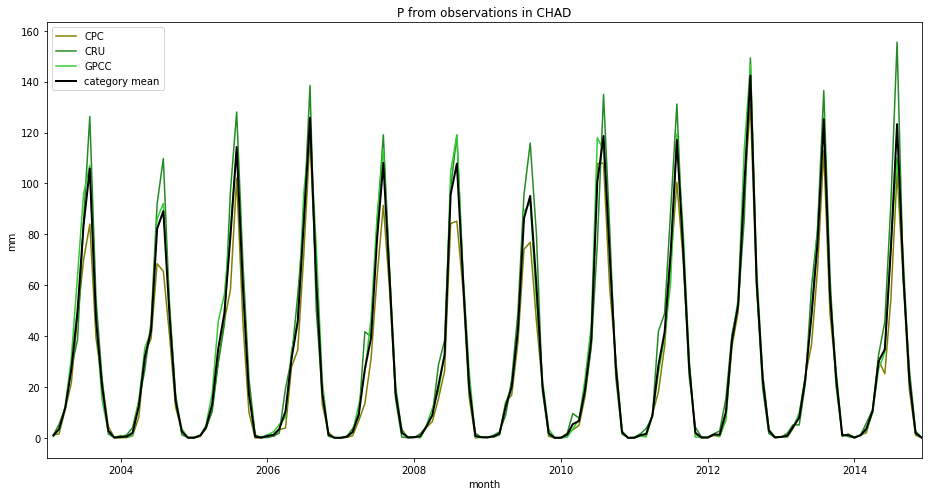

In [5]:
hydro_var_name='P'
category='observations'
basin_name='CHAD'


time_idx=pd.date_range(date(2003,2,1),date(2014,12,1),freq='MS')
list_data=give_datasets_in_category(hydro_var_name,category)

plt.figure(figsize=(13,7))

for data in list_data:
    hydro_month=pd.read_csv('../data/hydrology_timeseries/{}_{}_monthly.csv'.format(hydro_var_name,data),
                            index_col=[0])
    hydro_month.columns=hydro_month.columns.astype('datetime64[ns]')
    plt.plot(hydro_month.loc[basin_name,time_idx],color=colors_dataset[data],label=data)

# category mean
hydro_month=pd.read_csv('../data/hydrology_timeseries/{}_{}_monthly.csv'.format(hydro_var_name,category),
                            index_col=[0])
hydro_month.columns=hydro_month.columns.astype('datetime64[ns]')
plt.plot(hydro_month.loc[basin_name,time_idx],'k',linewidth=2,label='category mean')

plt.legend()
plt.xlim([date(2003,1,1),date(2014,12,1)])
plt.xlabel('month')
plt.ylabel('mm')
plt.title('{} from {} in {}'.format(hydro_var_name,category,basin_name))
plt.tight_layout()
plt.show()

# 2. <a id='part2'></a> Coefficients of variation

Load world maps as background

In [6]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

Available categories for each variable.

In [7]:
dict_category={'P':['reanalyses','observations','satellite',],
              'ET':['reanalyses','remote_sensing','land_surface_models'],
              'R':['reanalyses','land_surface_models']}

For a given hydrological variable, `columns` contains all the possible categories + the inter-category. For each category, we save the timeseries for all datasets. Then we compute the coefficient of variation (CV) as the standard deviation across datasets from the same category divided by the mean over those datasets.

In [8]:
hydro_var_name='R'

time_idx=pd.date_range(date(2003,2,1),date(2014,12,1),freq='MS')
columns=dict_category[hydro_var_name]+['inter category']
CV=pd.DataFrame(np.nan*np.ones((basins.shape[0],len(columns))),
               index=basins.index,columns=columns)

for category in dict_category[hydro_var_name]:
    list_data=give_datasets_in_category(hydro_var_name,category)
    
    multi_index=pd.MultiIndex.from_product([list_data,list(basins.index)], names=["dataset", "basin"])
    # each row of temp is a timeseries for a basin and a dataset
    temp=pd.DataFrame(np.nan*np.ones((multi_index.shape[0],time_idx.shape[0])),
                    index=multi_index,columns=time_idx)
    for data in list_data:
        hydro_month=pd.read_csv('../data/hydrology_timeseries/{}_{}_monthly.csv'.format(hydro_var_name,data),
                                index_col=[0])
        hydro_month.columns=hydro_month.columns.astype('datetime64[ns]')
        temp.loc[data]=hydro_month.loc[basins.index,time_idx].values
        
    # impose a denominator larger than 10mm to avoid large CVs during the dry season
    temp10=pd.DataFrame(np.where(temp<=10,10,temp),temp.index,temp.columns) 
    
    # the CV timeseries is the standard deviation across datasets divided by the mean
    CV_timeseries=temp.groupby(by='basin').std()/temp10.groupby(by='basin').mean()
    
    # We save the mean of the CV timeseries over all months
    CV[category]=CV_timeseries.mean(axis=1)
    
# Repeat the same procedure for inter-category    
category='inter category'
list_data=dict_category[hydro_var_name].copy()
if hydro_var_name=='R': # since GRUN is the only machine learning dataset, we add it as a standalone category
    list_data.append('GRUN')
    
multi_index=pd.MultiIndex.from_product([list_data,list(basins.index)], names=["dataset", "basin"])
temp=pd.DataFrame(np.nan*np.ones((multi_index.shape[0],time_idx.shape[0])),
                index=multi_index,columns=time_idx)
for data in list_data:
    hydro_month=pd.read_csv('../data/hydrology_timeseries/{}_{}_monthly.csv'.format(hydro_var_name,data),
                            index_col=[0])
    hydro_month.columns=hydro_month.columns.astype('datetime64[ns]')
    temp.loc[data]=hydro_month.loc[basins.index,time_idx].values

temp10=pd.DataFrame(np.where(temp<=10,10,temp),temp.index,temp.columns)
CV_timeseries=temp.groupby(by='basin').std()/temp10.groupby(by='basin').mean()
CV[category]=CV_timeseries.mean(axis=1)
CV=geopandas.GeoDataFrame(100*CV,geometry=basins['geometry'])

Plot the CVs for each basin

c:\users\fafal\miniconda3\lib\site-packages\geopandas\plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
c:\users\fafal\miniconda3\lib\site-packages\geopandas\plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
c:\users\fafal\miniconda3\lib\site-packages\geopandas\plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


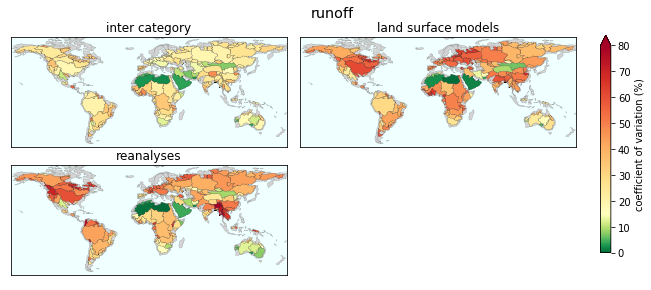

In [9]:
if hydro_var_name=='P':
    vmax=50
    var_long_name='precipitation'
elif hydro_var_name=='ET':
    vmax=70
    var_long_name='evapo-transpiration'
else:
    vmax=80
    var_long_name='runoff'
    
my_cmap = plt.cm.get_cmap('RdYlGn_r')
my_norm=MidpointNormalize(vmin=0,vmax=vmax,midpoint=15)

fig, axs = plt.subplots(2,2, figsize=(9.7,4))
list_ax=[axs[0,0],axs[1,0],axs[0,1],axs[1,1]]

for i,category in enumerate(['inter category']+dict_category[hydro_var_name]):
    ax=list_ax[i]
    ax.set_aspect('equal')
    world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
    CV.plot(ax=ax,column=category,
            edgecolor='black',linewidth=0.1,
            vmin=0,vmax=vmax,
            norm=my_norm,
            missing_kwds={"color": "lightgrey",'hatch':'////'},
            cmap=my_cmap, 
            )
    ax.set_facecolor('azure')
    ax.set_title(category.replace('_',' '))
    ax.set_xlim([-170,180])
    ax.set_ylim([-60,80])
    ax.set_xticks([])
    ax.set_yticks([])
    
if hydro_var_name=='R':
    axs[1,1].set_axis_off()
    
fig.colorbar(ScalarMappable(norm=my_norm,cmap=my_cmap), ax=axs, 
             orientation='vertical', 
             fraction=.02, # right space
             extend='max',
             label='coefficient of variation (%)'
            )
fig.suptitle(var_long_name,fontsize='x-large')
plt.subplots_adjust(left=0.04,right=0.85,bottom=0.02,top=0.9,wspace=0.05,hspace=0.02)
plt.show()